In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
from Session import SessionLite, build_flu_array_single
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder, largest_PC_trace, largest_PC_loading, do_pca
import loadpaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os, pickle, copy
from sklearn.decomposition import PCA
import warnings
import pandas as pd
import math, cmath
from tqdm import tqdm
import pop_off_functions as pof
import pop_off_plotting as pop
from IPython.core.debugger import Pdb
ipdb = Pdb()

# sys.path.append(os.path.expanduser('~/Documents/code/PtitPrince/pititprince'))
import ptitprince as pt

## Add paths:
user_paths_dict = loadpaths.loadpaths()

path_to_vape = user_paths_dict['vape_path']

sys.path.append(str(path_to_vape))
sys.path.append(str(os.path.join(path_to_vape, 'jupyter')))
sys.path.append(str(os.path.join(path_to_vape, 'utils')))

user_paths = loadpaths.loadpaths()
sys.path.append(user_paths['base_path'])
# figure_path = '/home/tplas/repos/optistim_results/'
# from pySpatialNeuronNet import factor_analysis


COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]


## Load data in form of Jimmy's PAS object
warnings.warn('Targets in data, fix self.ever_targetted')
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, subsample_sessions=False,
                         remove_targets=remove_targets, remove_toosoon = True)
lm = pas.linear_models[0]
print(pas.sessions)

/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 29 of Session class, 6: instance Mouse RL117, run 30 of Session class, 7: instance Mouse RL123, run 22 of Session class, 8: instance Mouse RL116, run 32 of Session class, 9: instance Mouse RL116, run 33 of Session class}


In [6]:
## Create sessions object from PAS:

try:  # ensure sessions doesn't exist yet 
    sessions
    assert type(sessions) is dict
except NameError:
    pass

sessions = {}
int_keys_pas_sessions = pas.sessions.keys()
print(int_keys_pas_sessions)
i_s = 0
for ses in pas.sessions.values():  # load into sessions dict (in case pas skips an int as key)
    ses.signature = f'{ses.mouse}_R{ses.run_number}'
    if ses.signature != 'RL117_R29':
        sessions[i_s] = ses
        i_s += 1
    else:
        f'{ses.signature} has been excluded !!! (because no spont data available)'
print(sessions)
assert len(sessions) == 10 - 1, 'talk to Jimmy - should be 10 sessions as of 3 June 2021'
pof.label_urh_arm(sessions=sessions)  # label arm and urh

# for kk, ss in sessions.items():
    
    
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')
tp_dict = pof.create_tp_dict(sessions=sessions)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 30 of Session class, 6: instance Mouse RL123, run 22 of Session class, 7: instance Mouse RL116, run 32 of Session class, 8: instance Mouse RL116, run 33 of Session class}
URH and ARM trials have been labelled
------------------------------------
9 sessions are loaded


In [8]:
sessions

{0: instance Mouse J064, run 10 of Session class,
 1: instance Mouse J064, run 11 of Session class,
 2: instance Mouse J064, run 14 of Session class,
 3: instance Mouse RL070, run 28 of Session class,
 4: instance Mouse RL070, run 29 of Session class,
 5: instance Mouse RL117, run 30 of Session class,
 6: instance Mouse RL123, run 22 of Session class,
 7: instance Mouse RL116, run 32 of Session class,
 8: instance Mouse RL116, run 33 of Session class}

# Behaviour


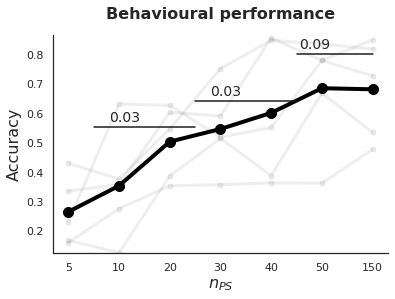

In [4]:
_ = pop.plot_behaviour_accuracy_all_mice(sessions=sessions)

In [20]:
## Shuffle data:
bool_shuffle_trials = False
bool_shuffle_s1s2 = False

for ii in range(len(sessions)):
    if bool_shuffle_trials:
        sessions[ii].shuffle_trial_labels()
    if bool_shuffle_s1s2:
        sessions[ii].shuffle_s1s2_labels()

# Raster plots


In [5]:
## session names
for i_s, ss in sessions.items():
    print(i_s, ss)

0 Mouse J064, run 10
1 Mouse J064, run 11
2 Mouse J064, run 14
3 Mouse RL070, run 28
4 Mouse RL070, run 29
5 Mouse RL117, run 29
6 Mouse RL117, run 30
7 Mouse RL123, run 22
8 Mouse RL116, run 32
9 Mouse RL116, run 33


## Plot single session example:

In [53]:
int(np.floor((ss.filter_ps_time[-1] + 4) / 2))
# ss.filter_ps_time[-1]  + 
# ss.filter_ps_time[-1]

5

[  0  60 120 180 240]
Mouse J064, run 14


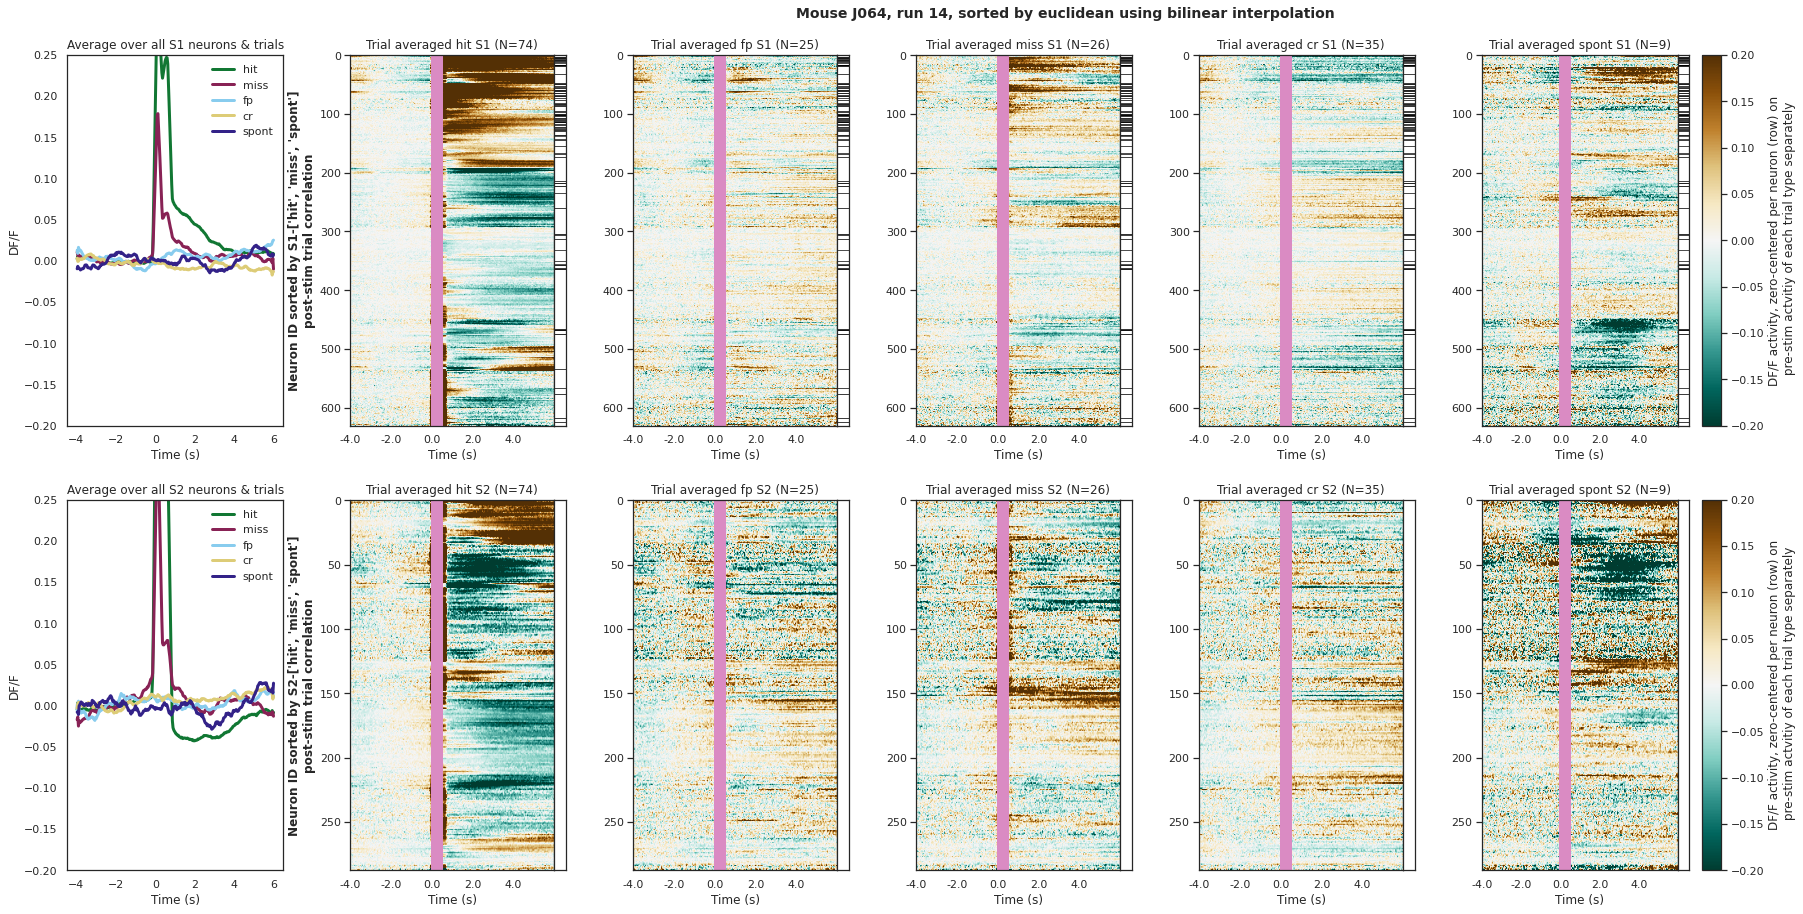

In [54]:
ss = sessions[2]  # select session
sorted_neurons_dict = pop.plot_raster_plots_trial_types_one_session(ss, sort_tt_list=['hit', 'miss', 'spont'], plot_averages=True,  ## sort_tt: what trial type to use to sort
                                                  save_fig=False, start_time=-4, imshow_interpolation='bilinear',  # interpolation method used for anti-aliasing: 'none' is no AA, 'bilinear' is standard AA
                                                            sorting_method='euclidean')#, s1_lim=[200, 0])#, s2_lim=[30, 0])  # see pop.sort_data_matrix() for possible sorting methods. s1_lim & s2_lim are ylims for s1 and s2
print(ss)

In [102]:
## Transform index of sorted cell of one region to global cell index
pop.transform_reg_sorted_cell_number(session=ss, sort_dict=sorted_neurons_dict, reg='S1', n_reg_sorted=415)

1

In [112]:
## Transform suite2p index of cell to global cell index
pop.transform_suite2p_cell_number(session=ss, n_suite2p=80)

68

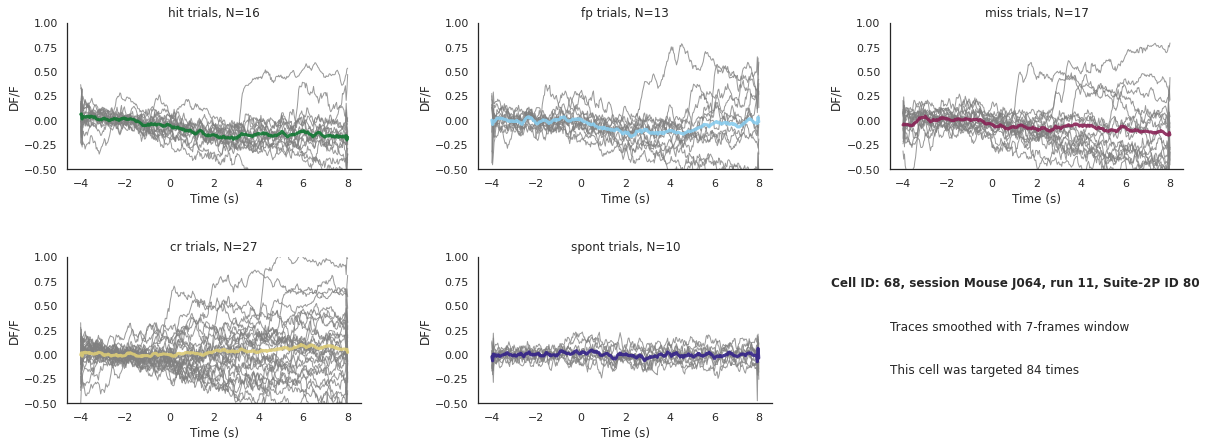

In [113]:
## Plot all single trial responses of a cell (with global cell index n)
pop.plot_single_cell_all_trials(session=ss, n=68, y_lim=[-0.5, 1])

## Save figures of all sessions:

In [57]:
## Trial-averaged raster plots (1 pdf per session)

for int_meth in ['none', 'bilinear']:
    for ii, ss in tqdm(sessions.items()):
        sorted_neurons_dict = pop.plot_raster_plots_trial_types_one_session(ss, sort_tt_list=['hit', 'miss', 'spont'], plot_averages=True,  ## sort_tt: what trial type to use to sort
                                                  save_fig=True, start_time=-4, imshow_interpolation=int_meth,  # interpolation method used for anti-aliasing: 'none' is no AA, 'bilinear' is standard AA
                                                            sorting_method='euclidean', show_plot=False)

100%|██████████| 9/9 [00:47<00:00,  5.26s/it]


In [24]:
## Single trial overview

for reg in ['S1', 'S2']:
    print(reg)
    for tt_plot in ['hit', 'miss', 'fp', 'cr', 'spont']:
        print(tt_plot)
        for interp_meth in ['none']:
            for ss in sessions.values():
                pop.plot_raster_plots_all_trials_one_session(ss, sort_tt='hit', tt_plot=tt_plot,
                                                             save_fig=True, start_time=-4, imshow_interpolation=interp_meth,
                                                             sorting_method='euclidean', reg=reg,
                                                             show_plot=False,
                                                             save_folder='/home/tplas/repos/popping-off/figures/raster_plots/individual_trials/' + interp_meth)#, s1_lim=[380, 330]) 

S1
hit
miss
fp
cr
spont
S2
hit
miss
fp
cr
spont


# Other info about trials

Mouse J064, run 10
N cells stim ever 162


(0.0, 50.0)

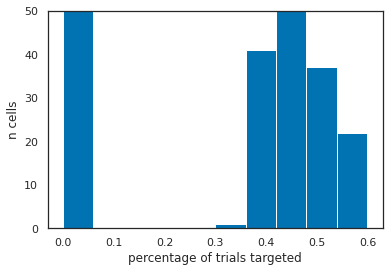

In [87]:
times_targ = np.mean(sessions[6].is_target[:, :, 10], 1)
print(sessions[2])
print('N cells stim ever', np.sum(times_targ > 0))
plt.hist(times_targ)
plt.xlabel('percentage of trials targeted')
plt.ylabel('n cells')
plt.ylim([0, 50])

Text(0, 0.5, 'Number of cells stim measured')

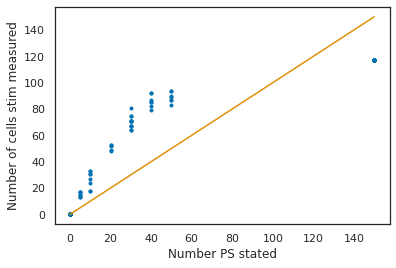

In [101]:
plt.plot(sessions[2].trial_subsets, np.sum(sessions[2].is_target[:, :, 10], 0), '.')
plt.plot([0, 150], [0, 150])
plt.xlabel('Number PS stated')
plt.ylabel('Number of cells stim measured')
# # sessions[2].trial_subsets
# sessions[2].behaviour_trials.shape

100%|██████████| 7/7 [00:00<00:00, 39.64it/s]


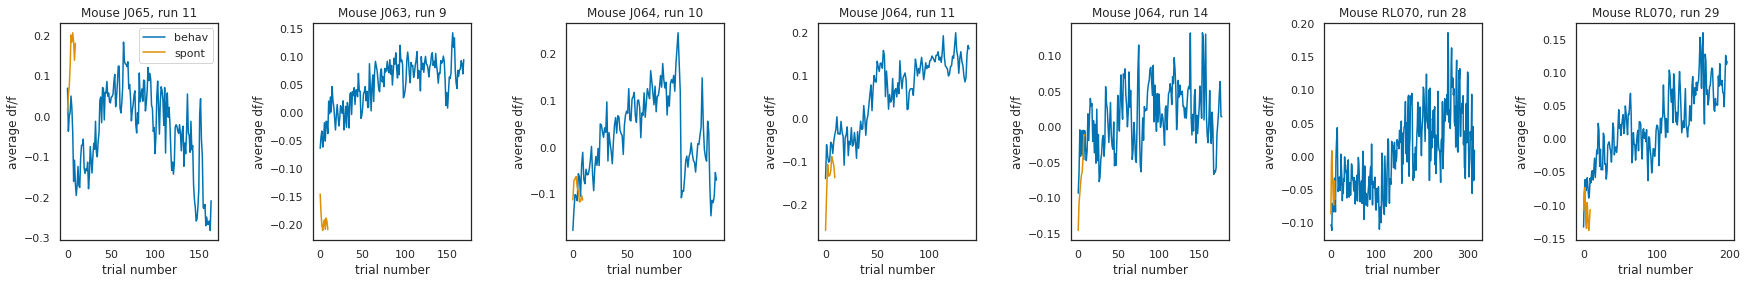

In [55]:
# plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots(1, len(sessions), figsize=(30, 4), gridspec_kw={'wspace': 0.6
                                                                      })
for i_ss, ss in tqdm(sessions.items()):
    # ss = sessions[5]
#     std_arr = np.zeros(ss.behaviour_trials.shape[1])
#     for n_trial in range(ss.behaviour_trials.shape[1]):
#         std_arr[n_trial] = np.std(np.mean(ss.behaviour_trials[:, n_trial :][:, :230], 1))
    mean_arr = np.mean(ss.behaviour_trials, (0, 2))
    ax[i_ss].plot(mean_arr, label='behav')
    mean_arr = np.mean(ss.pre_rew_trials, (0, 2))
    ax[i_ss].plot(mean_arr, label='spont')
#     ax[i_ss].fill_between(x=np.arange(len(mean_arr)), y1=mean_arr - std_arr, y2=mean_arr + std_arr, alpha=0.2)
    ax[i_ss].set_xlabel('trial number')
    ax[i_ss].set_ylabel('average df/f')
    ax[i_ss].set_title(ss)
ax[0].legend()


In [50]:
session.pre_reward_trials

AttributeError: 'SessionLite' object has no attribute 'pre_reward_trials'

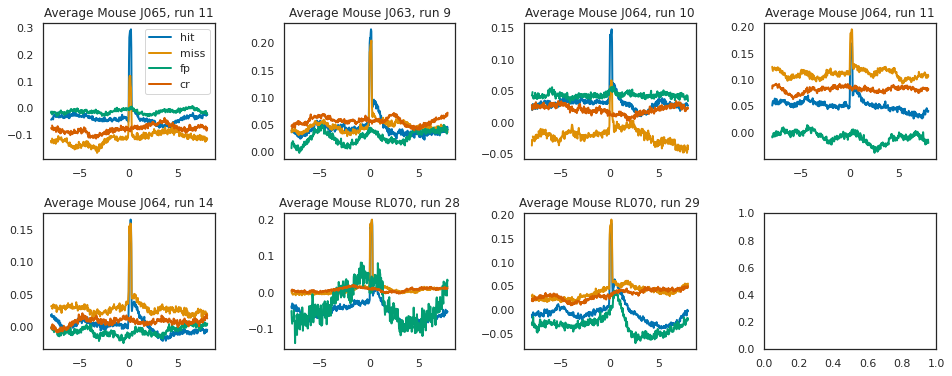

In [70]:
pop.plot_mean_traces_per_session(sessions=sessions)

In [6]:
df_differences = pof.create_df_differences(sessions=sessions)

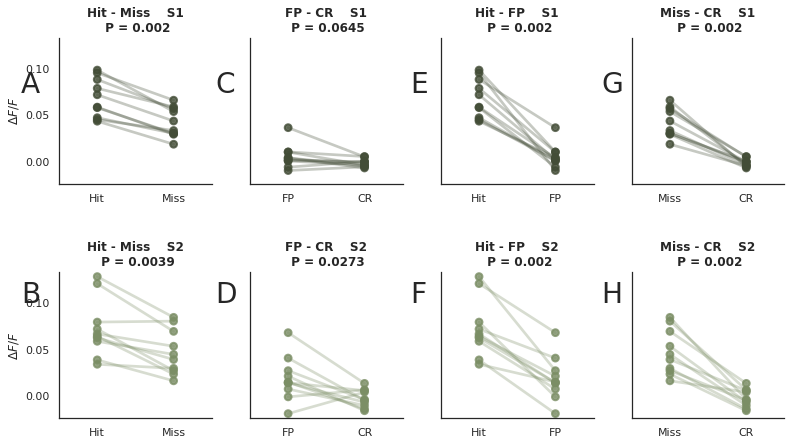

In [7]:
pop.plot_trial_type_mean_differences_pointplots(sessions=sessions, df_differences=df_differences)

In [83]:
df_dyn_differences = pof.create_df_dyn_differences(sessions=sessions, tp_dict=tp_dict)

100%|██████████| 7/7 [18:50<00:00, 161.53s/it]


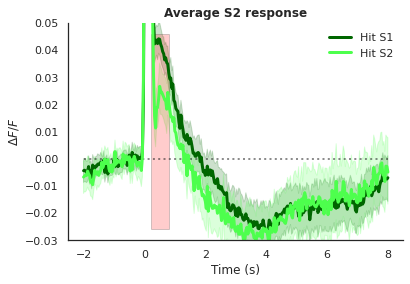

In [90]:
pop.plot_mean_trace_across_sessions(df_dyn_differences=df_dyn_differences)

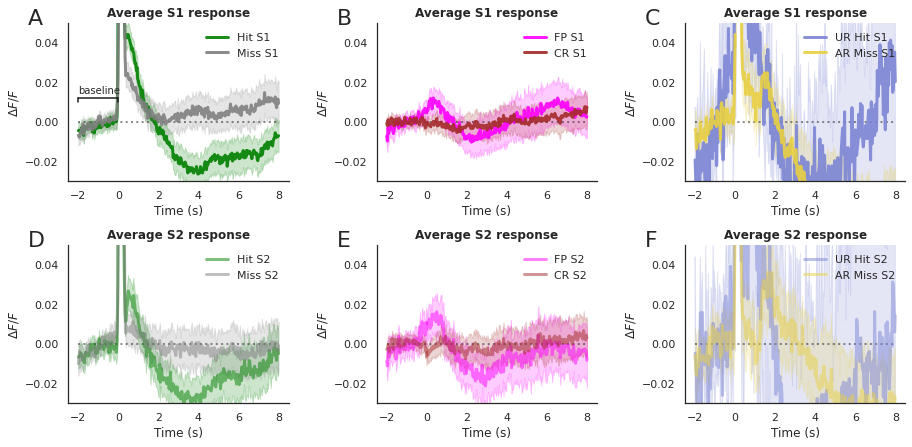

In [101]:
pop.plot_mean_trace_overview_across_sessions(df_dyn_differences=df_dyn_differences)

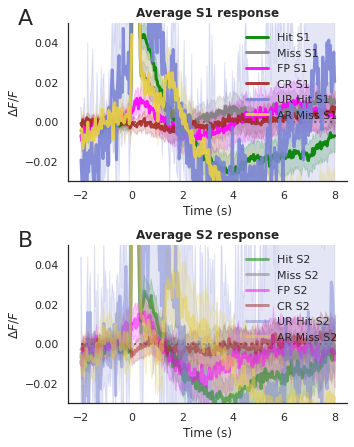

In [103]:
pop.plot_mean_trace_overview_across_sessions(df_dyn_differences=df_dyn_differences,
                                             tuple_list_tt=[('hit', 'miss', 'fp', 'cr', 'ur_hit', 'ar_miss')])

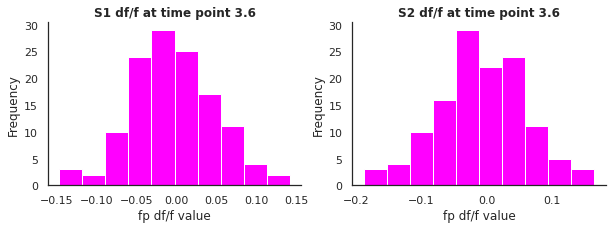

In [66]:
## Inspect data:
df = df_dyn_differences
tp = 3.6
tt = 'fp'
assert tp in np.unique(df['timepoint'])
assert tt in np.unique(df['trial_type'])
assert 'S1' in np.unique(df['region'])
assert 'S2' in np.unique(df['region'])
plt.rcParams['figure.figsize'] = (10, 3)
for i_reg, reg in enumerate(['s1', 's2']):
    plt.subplot(1, 2, 1 + i_reg)
    plt.hist(df[np.logical_and(df['trial_type'] == tt, np.logical_and(np.isclose(df['timepoint'], tp),
                               df['region'] == reg.upper()))]['diff_dff'],
            color=color_tt['fp'])
    plt.xlabel(f'{tt} df/f value'); plt.ylabel('Frequency'); 
    plt.title(f'{reg.upper()} df/f at time point {tp}', weight='bold');
sns.despine()

## Single time point decoder example:

Mouse J064, Starting loop 1/1


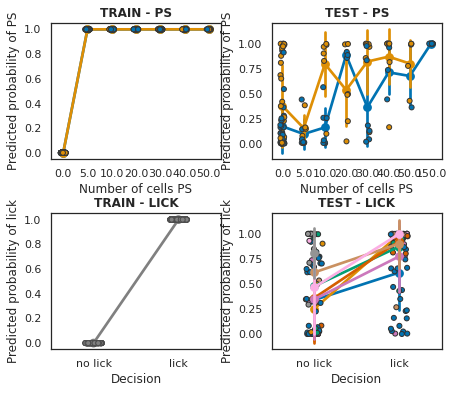

In [8]:
_ = pop.plot_single_session_single_tp_decoding_performance(session=sessions[2])

In [131]:
tmp_df = _[1]['J064']
# tmp_df[70:]
tmp_df[tmp_df['outcome_test'] == 'spont']
# tmp_df[tmp_df['used_for_training'] == 1]#['autorewarded_miss_test'].sum()

autorewarded_miss_test  unrewarded_hit_test outcome_test  pred_dec_test  \
21                     0.0                  0.0        spont       0.999965   
22                     0.0                  0.0        spont       1.000000   
23                     0.0                  0.0        spont       0.999999   
45                     0.0                  0.0        spont       0.999970   
46                     0.0                  0.0        spont       0.999945   
47                     0.0                  0.0        spont       0.999499   
69                     0.0                  0.0        spont       0.969975   
70                     0.0                  0.0        spont       0.994839   
92                     0.0                  0.0        spont       0.999873   
93                     0.0                  0.0        spont       0.998822   

    pred_stim_test  true_dec_test  true_stim_test  true_reward_test  \
21    5.518834e-07            1.0             0.0               1.0   
22    2.453477e-07            1.0             0.0               1.0   
23    9.836776e-07            1.0             0.0               1.0   
45    8.518019e-06            1.0             0.0               1.0   
46    9.031394e-05            1.0             0.0               1.0   
47    2.522845e-04            1.0             0.0               1.0   
69    3.975362e-05            1.0             0.0               1.0   
70    9.412941e-05            1.0             0.0               1.0   
92    1.471778e-05            1.0             0.0               1.0   
93    1.881513e-04            1.0             0.0               1.0   

    used_for_training  
21                1.0  
22                1.0  
23                1.0  
45                1.0  
46                1.0  
47                1.0  
69                1.0  
70                1.0  
92                1.0  
93                1.0

In [6]:
## Inspect influence autorewards:
# mouse = 'J048'
# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 1,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 0,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][df_prediction_test[mouse]['true_stim_test'] > 0 ]['pred_dec_test'].mean())

## Check single neurons

In [109]:
# dw = decoder_weights['s1_stim']['J048_R29']
# dw_as = np.argsort(np.sum(dw, 1))[::-1]

# plt.rcParams['figure.figsize'] = (8, 8)
# plt.imshow(dw[dw_as, :], aspect='auto', cmap='PiYG', vmin=-0.5, vmax=0.5)
# plt.colorbar()
# # plt.plot(np.mean(np.abs(dw[dw_as[900:], :]), 0))

# dw_as[300]

In [110]:
# s2_inds = np.where(sessions[2].s1_bool)[0]
# plt.rcParams['figure.figsize'] = (9, 5)
# neuron_data = sessions[2].behaviour_trials[s2_inds[dw_as[6]], :,:][:, sessions[2].filter_ps_array]
# for tt in ['hit', 'miss', 'fp', 'cr']:
#     plt.plot(np.mean(neuron_data[sessions[2].outcome == tt, :], 0), label=tt)
# # for tt in [0, 1]:
# #     plt.plot(np.mean(neuron_data[sessions[2].decision == tt, :], 0), label=tt)

# plt.legend()

## Train dynamic decoders:

In [9]:
tp_dict['decoders'] = tp_dict['mutual']#[np.logical_and(tp_dict['mutual'] >-2]#, tp_dict['mutual'] <= 4)]

In [29]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, ps_pred_split, lick_half, 
     angle_dec, decoder_weights) = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                               time_array=tp_dict['decoders'][:280:10],
                                              projected_data=False, 
                                              reg_type='l2', regularizer=50,  #reg_type='none',
                                              average_fun=pof.class_av_mean_accuracy,
                                              split_fourway=True)

28it [02:20,  5.00s/it]


In [114]:
violin_df_test = pof.get_decoder_data_for_violin_plots(sessions=sessions,
                                                       tp_list=[1.0, 4.0])


Number of trials for mouse J063: 107, multiplications: 93.46
Number of trials for mouse J064: 299, multiplications: 33.44
Number of trials for mouse J065: 101, multiplications: 99.01
Number of trials for mouse RL070: 319, multiplications: 31.35
Corrected number of trials for mouse J063: 19902
Corrected number of trials for mouse J064: 19734
Corrected number of trials for mouse J065: 19998
Corrected number of trials for mouse RL070: 19778


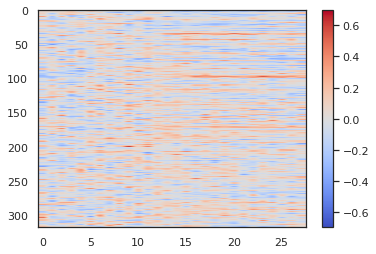

In [42]:
plt.imshow(decoder_weights['s1_stim']['J064_R10'], aspect='auto', cmap='coolwarm' ,vmin=-0.7, vmax=0.7)
plt.colorbar()

## Create PS decoding summary plot

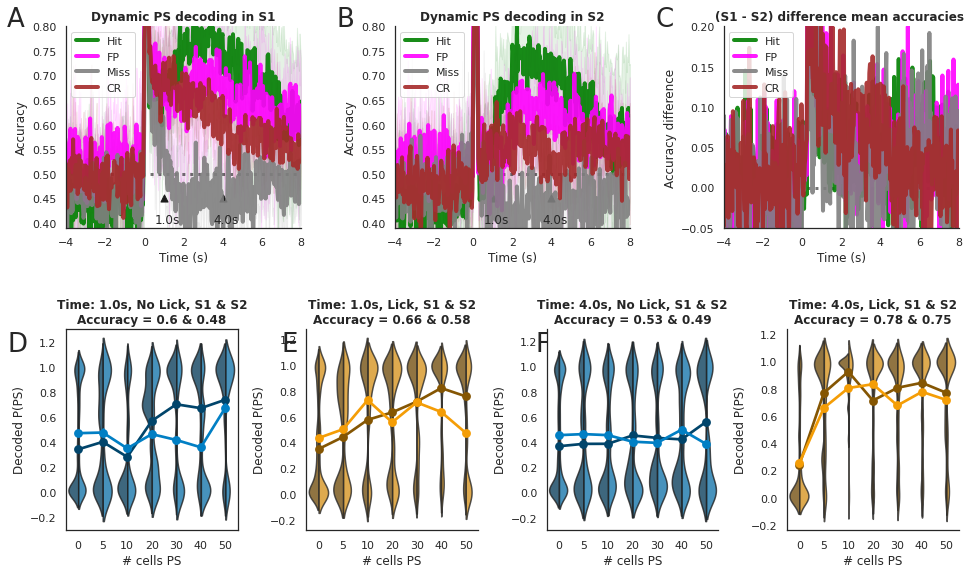

In [124]:
pop.plot_dyn_stim_decoding_compiled_summary_figure(ps_acc_split=ps_acc_split,
                                          violin_df_test=violin_df_test,
                                          time_array=tp_dict['decoders'])

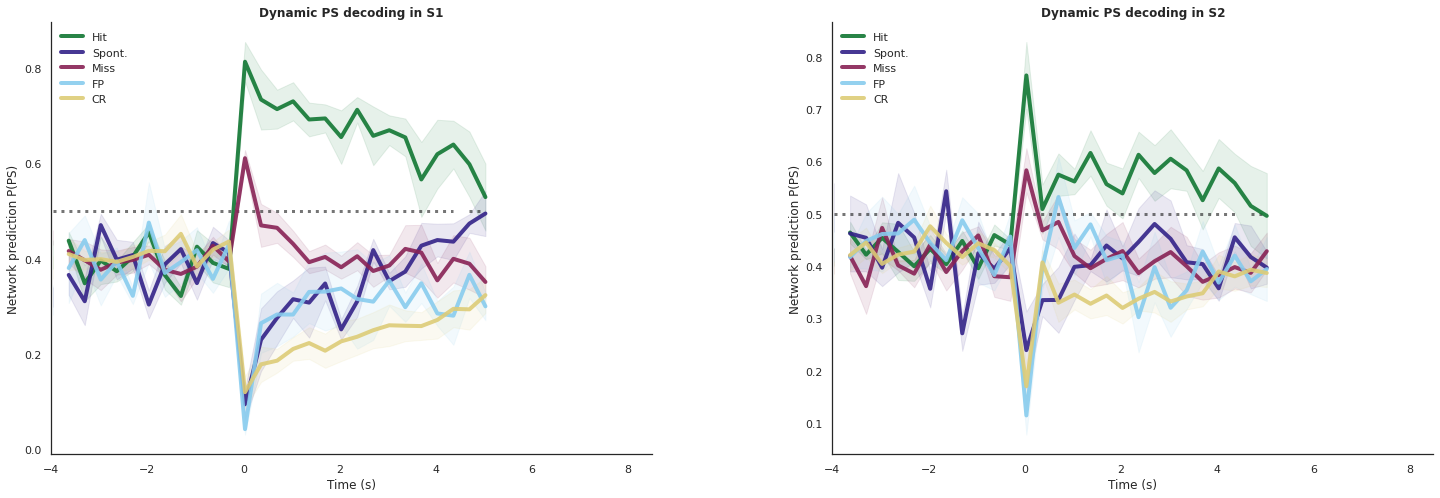

In [18]:
## Spont used for training

plot_tt = ['hit', 'spont', 'miss', 'fp', 'cr']
plot_dict_split = {x: ps_pred_split[x] for x in plot_tt}
pop.plot_dynamic_decoding_two_regions(ps_acc_split=plot_dict_split,
                                      time_array=tp_dict['decoders'][:280:10],
                                      yaxis_type='prediction', 
                                      smooth_traces=False,
                                      one_sided_window_size=3,
                                      save_fig=False,
                                      plot_indiv=False,
                                      plot_std_area=True)

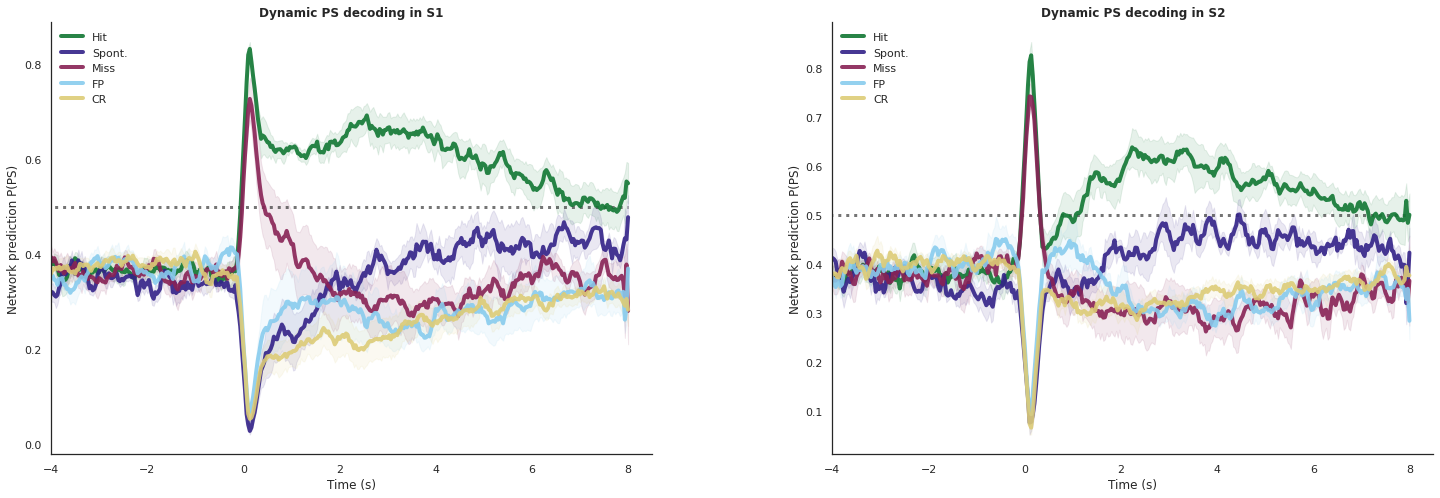

In [12]:
plot_tt = ['hit', 'spont', 'miss', 'fp', 'cr']
plot_dict_split = {x: ps_pred_split[x] for x in plot_tt}
pop.plot_dynamic_decoding_two_regions(ps_acc_split=plot_dict_split,
                                      time_array=tp_dict['decoders'],
                                      yaxis_type='prediction', 
                                      smooth_traces=True,
                                      one_sided_window_size=3,
                                      save_fig=False,
                                      plot_indiv=False,
                                      plot_std_area=True)

In [425]:
for ss in sessions.values():
    print(ss.unrewarded_hits.sum(), ss)
for k, v in lick_acc_split['urh'].items():
    print(k, np.mean(v))

1 Mouse J065, run 11
0 Mouse J063, run 9
5 Mouse J064, run 10
0 Mouse J064, run 11
0 Mouse J064, run 14
5 Mouse RL070, run 28
3 Mouse RL070, run 29
J063_s1 nan
J063_s2 nan
J064_s1 0.36158813377148136
J064_s2 0.34341436976202466
J065_s1 0.009112875300471219
J065_s2 0.025400511377793523
RL070_s1 0.48683535681181916
RL070_s2 0.48685566115433615


<AxesSubplot:xlabel='true_stim_test', ylabel='pred_stim_test'>

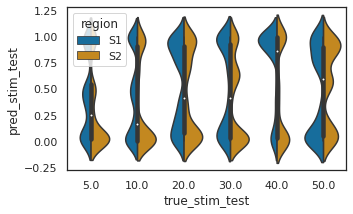

In [322]:
plot_df = violin_df_test[1.8][violin_df_test[1.8]['outcome_test'] == 'miss']
sns.violinplot(data=plot_df, 
               x='true_stim_test',
               y='pred_stim_test',
               hue='region', split=True)

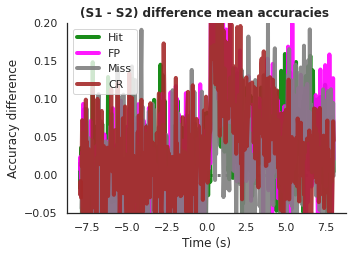

In [128]:
## Same plot as previous figure panel C; to only show difference in case of shuffled labels

## NB: THIS MUST BE DONE BY SHUFFLING THE DATA BEFOREHAND (SEE TOP OF NB)

pop.plot_dynamic_decoding_region_difference_panel(time_array=tp_dict['decoders'],
                                                  ps_acc_split=ps_acc_split
                                                  )
sns.despine()
# plt.savefig('figures/shuffled_s1s2_ps_decoding_difference.pdf', bbox_inches='tight')

## Lick decoding

In [146]:
violin_df_test = pof.get_decoder_data_for_violin_plots(sessions=sessions,
                                                       tp_list=[1.8])


Number of trials for mouse J063: 107, multiplications: 93.46
Number of trials for mouse J064: 299, multiplications: 33.44
Number of trials for mouse J065: 101, multiplications: 99.01
Number of trials for mouse RL070: 319, multiplications: 31.35
Corrected number of trials for mouse J063: 19902
Corrected number of trials for mouse J064: 19734
Corrected number of trials for mouse J065: 19998
Corrected number of trials for mouse RL070: 19778


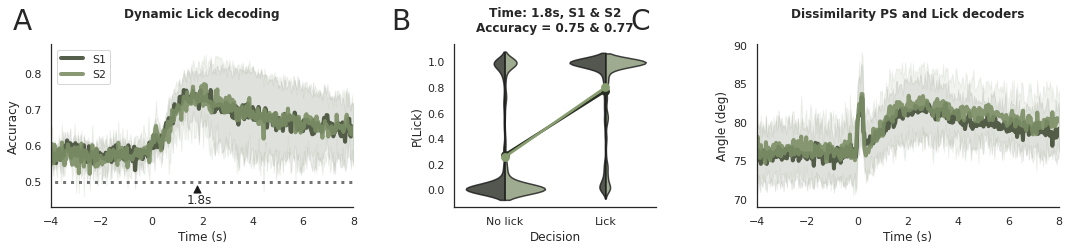

In [147]:
pop.plot_dyn_lick_decoding_compiled_summary_figure(violin_df_test=violin_df_test, 
                                                   time_array=tp_dict['decoders'], 
                                                   lick_acc=lick_acc, angle_dec=angle_dec)

# Supplemental figs

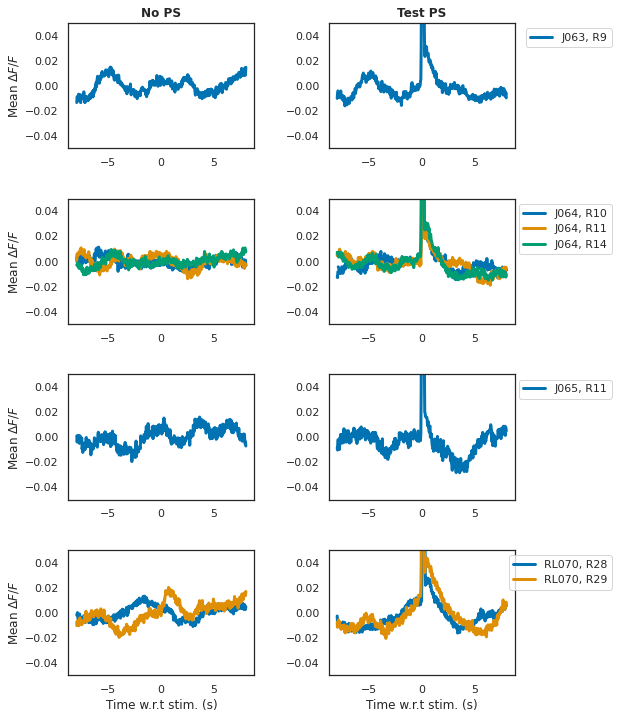

In [150]:
pop.plot_average_ps_traces_per_mouse(sessions=sessions)

## Cross validate regularization value

Idea:
  - It depends on number of neurons. So either scale with n_neurons, but I'm not sure what scaling (e.g. linear) this is.. So instead we'll optimise per session. S1/S2 are about 50/50 so we'll ignore this (also because their perfomance varies)
  - Per session; evaluate 3 seconds post stim at 5Hz. Find the maximum test decoding accuracy (for both decoders). we'll take the corresponding C value.
  - Save in some file because this takes some time to run

In [374]:
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
                 angle_dec, dec_weights) = pof.compute_accuracy_time_array(sessions={0: sessions[0]}, time_array=tp_dict['cv_reg'],
                                                              projected_data=False, reg_type='none',
                                                              region_list=['s1'],
                                                              average_fun=pof.class_av_mean_accuracy)

11it [00:02,  4.39it/s]


In [377]:
## Integrate different imaging frequencies:
assert 'mutual' in tp_dict.keys()
tp_dict['cv_reg'] = tp_dict['mutual'][np.logical_and(tp_dict['mutual'] <= 3, tp_dict['mutual'] > 0)]  # Use all time points < 3 post stim
c_value_array = np.array([50, 20, 5, 2, 0.5, 0.2, 0.05, 0.02, 0.005, 0.002])  # list of C values, where 1/C is reg strength
    
dict_cv_results = {}
for reg in ['s1', 's2']:
    print(f'---------------\n{reg}\n-------------\n')
    dict_cv_results[reg] = pof.perform_logreg_cv(sessions=sessions, 
                                                 c_value_array=c_value_array, 
                                                 reg_list=[reg])

0it [00:00, ?it/s]

---------------
s1
-------------

Mouse RL070, run 28


11it [00:02,  4.04it/s]
11it [00:03,  3.26it/s]
11it [00:03,  3.39it/s]
11it [00:03,  3.39it/s]
11it [00:03,  3.36it/s]
11it [00:03,  3.49it/s]
11it [00:03,  3.55it/s]
11it [00:03,  3.39it/s]
11it [00:03,  3.63it/s]
11it [00:02,  3.75it/s]
11it [00:02,  3.88it/s]
0it [00:00, ?it/s]

Mouse RL070, run 29


11it [00:02,  4.84it/s]
11it [00:02,  4.16it/s]
11it [00:02,  4.30it/s]
11it [00:02,  4.15it/s]
11it [00:02,  4.38it/s]
11it [00:02,  4.46it/s]
11it [00:02,  4.63it/s]
11it [00:02,  4.96it/s]
11it [00:02,  5.16it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.50it/s]
1it [00:00,  7.46it/s]

Mouse J048, run 27


11it [00:01,  7.40it/s]
11it [00:01,  5.62it/s]
11it [00:01,  5.66it/s]
11it [00:01,  5.71it/s]
11it [00:01,  5.65it/s]
11it [00:01,  5.79it/s]
11it [00:01,  5.90it/s]
11it [00:01,  6.23it/s]
11it [00:01,  6.49it/s]
11it [00:01,  7.24it/s]
11it [00:01,  7.97it/s]
1it [00:00,  6.91it/s]

Mouse J048, run 28


11it [00:01,  6.85it/s]
11it [00:02,  5.41it/s]
11it [00:02,  5.34it/s]
11it [00:02,  5.34it/s]
11it [00:02,  5.26it/s]
11it [00:02,  5.36it/s]
11it [00:01,  5.56it/s]
11it [00:01,  5.70it/s]
11it [00:01,  6.01it/s]
11it [00:01,  6.88it/s]
11it [00:01,  6.93it/s]
1it [00:00,  5.77it/s]

Mouse J048, run 29


11it [00:01,  5.78it/s]
11it [00:03,  3.54it/s]
11it [00:03,  3.50it/s]
11it [00:03,  3.37it/s]
11it [00:03,  3.38it/s]
11it [00:03,  3.40it/s]
11it [00:03,  3.38it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.85it/s]
11it [00:02,  5.48it/s]
11it [00:02,  5.46it/s]
1it [00:00,  6.08it/s]

Mouse J048, run 30


11it [00:01,  6.11it/s]
11it [00:02,  4.04it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.15it/s]
11it [00:03,  3.18it/s]
11it [00:02,  3.70it/s]
11it [00:02,  4.42it/s]
11it [00:02,  4.75it/s]
11it [00:02,  5.01it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.32it/s]
1it [00:00,  5.73it/s]

Mouse J048, run 32


11it [00:01,  5.75it/s]
11it [00:02,  3.83it/s]
11it [00:02,  3.76it/s]
11it [00:03,  3.22it/s]
11it [00:02,  3.80it/s]
11it [00:03,  3.51it/s]
11it [00:02,  3.69it/s]
11it [00:02,  4.03it/s]
11it [00:02,  4.12it/s]
11it [00:02,  5.02it/s]
11it [00:02,  5.34it/s]
1it [00:00,  7.34it/s]

Mouse J064, run 10


11it [00:01,  7.68it/s]
11it [00:01,  5.66it/s]
11it [00:01,  5.79it/s]
11it [00:01,  5.78it/s]
11it [00:01,  5.77it/s]
11it [00:01,  6.12it/s]
11it [00:01,  6.43it/s]
11it [00:01,  7.30it/s]
11it [00:01,  7.79it/s]
11it [00:01,  8.39it/s]
11it [00:01,  8.47it/s]
1it [00:00,  6.12it/s]

Mouse J064, run 11


11it [00:01,  6.21it/s]
11it [00:02,  4.98it/s]
11it [00:02,  4.99it/s]
11it [00:02,  4.69it/s]
11it [00:02,  4.60it/s]
11it [00:02,  5.17it/s]
11it [00:02,  5.30it/s]
11it [00:01,  5.69it/s]
11it [00:01,  5.98it/s]
11it [00:01,  6.45it/s]
11it [00:01,  6.55it/s]
0it [00:00, ?it/s]

Mouse J064, run 14


11it [00:02,  5.01it/s]
11it [00:02,  4.16it/s]
11it [00:02,  4.14it/s]
11it [00:02,  4.12it/s]
11it [00:02,  4.14it/s]
11it [00:02,  4.21it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.65it/s]
11it [00:02,  4.82it/s]
11it [00:02,  5.10it/s]
11it [00:02,  5.22it/s]
2it [00:00, 11.18it/s]

Mouse J063, run 8


11it [00:00, 12.64it/s]
11it [00:01,  9.13it/s]
11it [00:01,  8.98it/s]
11it [00:01,  9.56it/s]
11it [00:01, 10.06it/s]
11it [00:00, 11.12it/s]
11it [00:00, 12.45it/s]
11it [00:00, 14.04it/s]
11it [00:00, 14.84it/s]
11it [00:00, 14.97it/s]
11it [00:00, 15.04it/s]
1it [00:00,  6.19it/s]

Mouse J063, run 9


11it [00:01,  6.41it/s]
11it [00:02,  5.30it/s]
11it [00:02,  5.27it/s]
11it [00:02,  5.29it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.34it/s]
11it [00:01,  5.59it/s]
11it [00:01,  6.03it/s]
11it [00:01,  6.48it/s]
11it [00:01,  6.94it/s]
11it [00:01,  6.91it/s]
1it [00:00,  5.25it/s]

Mouse RL048, run 23


11it [00:02,  5.43it/s]
11it [00:02,  3.91it/s]
11it [00:03,  3.59it/s]
11it [00:02,  3.92it/s]
11it [00:02,  4.04it/s]
11it [00:02,  3.88it/s]
11it [00:02,  4.18it/s]
11it [00:02,  4.23it/s]
11it [00:02,  4.67it/s]
11it [00:02,  4.86it/s]
11it [00:02,  4.95it/s]
1it [00:00,  5.81it/s]

Mouse RL048, run 24


11it [00:02,  5.14it/s]
11it [00:02,  4.04it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.45it/s]
11it [00:02,  4.43it/s]
11it [00:02,  4.50it/s]
11it [00:02,  4.70it/s]
11it [00:02,  4.44it/s]
11it [00:02,  5.16it/s]
11it [00:02,  5.48it/s]
11it [00:01,  5.83it/s]
0it [00:00, ?it/s]

Mouse RL048, run 25


11it [00:03,  3.63it/s]
11it [00:04,  2.57it/s]
11it [00:03,  2.76it/s]
11it [00:04,  2.65it/s]
11it [00:03,  2.91it/s]
11it [00:03,  2.88it/s]
11it [00:03,  2.89it/s]
11it [00:03,  3.15it/s]
11it [00:03,  2.83it/s]
11it [00:03,  2.88it/s]
11it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Mouse RL048, run 28


11it [00:03,  3.25it/s]
11it [00:04,  2.27it/s]
11it [00:04,  2.36it/s]
11it [00:04,  2.50it/s]
11it [00:04,  2.48it/s]
11it [00:03,  2.82it/s]
11it [00:04,  2.71it/s]
11it [00:03,  3.33it/s]
11it [00:03,  3.34it/s]
11it [00:03,  3.61it/s]
11it [00:02,  3.89it/s]
0it [00:00, ?it/s]

Mouse RL048, run 29


11it [00:02,  4.93it/s]
11it [00:02,  3.69it/s]
11it [00:03,  3.57it/s]
11it [00:03,  3.36it/s]
11it [00:03,  3.51it/s]
11it [00:02,  3.89it/s]
11it [00:02,  4.04it/s]
11it [00:02,  3.81it/s]
11it [00:02,  4.71it/s]
11it [00:02,  4.60it/s]
11it [00:01,  5.56it/s]
1it [00:00,  8.24it/s]

Mouse J065, run 10


11it [00:01,  9.28it/s]
11it [00:02,  5.47it/s]
11it [00:01,  5.73it/s]
11it [00:01,  6.28it/s]
11it [00:01,  7.09it/s]
11it [00:01,  8.88it/s]
11it [00:01, 10.52it/s]
11it [00:00, 11.72it/s]
11it [00:00, 12.42it/s]
11it [00:00, 12.80it/s]
11it [00:00, 12.79it/s]
1it [00:00,  7.82it/s]

Mouse J065, run 11


11it [00:01,  7.75it/s]
11it [00:01,  6.07it/s]
11it [00:01,  6.03it/s]
11it [00:01,  6.01it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.31it/s]
11it [00:01,  6.63it/s]
11it [00:01,  7.28it/s]
11it [00:01,  7.75it/s]
11it [00:01,  8.07it/s]
11it [00:01,  8.37it/s]
0it [00:00, ?it/s]

---------------
s2
-------------

Mouse RL070, run 28


11it [00:02,  4.61it/s]
11it [00:03,  3.47it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.21it/s]
11it [00:03,  3.00it/s]
11it [00:03,  3.58it/s]
11it [00:02,  3.67it/s]
11it [00:02,  4.13it/s]
11it [00:02,  4.35it/s]
11it [00:02,  4.72it/s]
11it [00:02,  4.84it/s]
1it [00:00,  5.23it/s]

Mouse RL070, run 29


11it [00:02,  5.35it/s]
11it [00:02,  4.56it/s]
11it [00:02,  4.66it/s]
11it [00:02,  4.66it/s]
11it [00:02,  4.75it/s]
11it [00:02,  4.94it/s]
11it [00:02,  5.14it/s]
11it [00:01,  5.50it/s]
11it [00:01,  5.72it/s]
11it [00:01,  6.08it/s]
11it [00:01,  6.08it/s]
1it [00:00,  6.99it/s]

Mouse J048, run 27


11it [00:01,  7.05it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.26it/s]
11it [00:02,  5.24it/s]
11it [00:02,  5.21it/s]
11it [00:02,  5.40it/s]
11it [00:01,  5.56it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.36it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.41it/s]
1it [00:00,  6.72it/s]

Mouse J048, run 28


11it [00:01,  6.65it/s]
11it [00:02,  5.20it/s]
11it [00:02,  5.15it/s]
11it [00:02,  5.11it/s]
11it [00:02,  5.05it/s]
11it [00:02,  5.15it/s]
11it [00:02,  5.36it/s]
11it [00:01,  5.63it/s]
11it [00:01,  5.99it/s]
11it [00:01,  6.58it/s]
11it [00:01,  6.81it/s]
1it [00:00,  5.76it/s]

Mouse J048, run 29


11it [00:02,  5.48it/s]
11it [00:03,  3.55it/s]
11it [00:03,  3.41it/s]
11it [00:03,  3.46it/s]
11it [00:03,  3.56it/s]
11it [00:03,  3.16it/s]
11it [00:03,  3.07it/s]
11it [00:03,  3.61it/s]
11it [00:02,  4.04it/s]
11it [00:02,  4.38it/s]
11it [00:02,  5.12it/s]
0it [00:00, ?it/s]

Mouse J048, run 30


11it [00:02,  4.44it/s]
11it [00:02,  3.82it/s]
11it [00:03,  3.52it/s]
11it [00:02,  3.78it/s]
11it [00:03,  3.23it/s]
11it [00:03,  3.29it/s]
11it [00:03,  3.37it/s]
11it [00:02,  4.43it/s]
11it [00:02,  4.46it/s]
11it [00:02,  4.87it/s]
11it [00:02,  5.09it/s]
1it [00:00,  5.56it/s]

Mouse J048, run 32


11it [00:02,  5.14it/s]
11it [00:02,  3.80it/s]
11it [00:02,  3.95it/s]
11it [00:03,  3.61it/s]
11it [00:02,  3.84it/s]
11it [00:02,  3.70it/s]
11it [00:02,  4.18it/s]
11it [00:02,  4.32it/s]
11it [00:02,  5.07it/s]
11it [00:01,  5.67it/s]
11it [00:02,  4.95it/s]
1it [00:00,  6.34it/s]

Mouse J064, run 10


11it [00:01,  7.76it/s]
11it [00:01,  5.92it/s]
11it [00:01,  5.66it/s]
11it [00:01,  5.95it/s]
11it [00:01,  6.09it/s]
11it [00:01,  6.49it/s]
11it [00:01,  6.87it/s]
11it [00:01,  7.68it/s]
11it [00:01,  8.15it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.57it/s]
1it [00:00,  6.42it/s]

Mouse J064, run 11


11it [00:01,  6.67it/s]
11it [00:02,  5.32it/s]
11it [00:02,  5.27it/s]
11it [00:02,  5.31it/s]
11it [00:02,  5.40it/s]
11it [00:01,  5.57it/s]
11it [00:01,  5.83it/s]
11it [00:01,  6.28it/s]
11it [00:01,  6.64it/s]
11it [00:01,  7.13it/s]
11it [00:01,  7.21it/s]
1it [00:00,  5.23it/s]

Mouse J064, run 14


11it [00:02,  5.17it/s]
11it [00:02,  4.20it/s]
11it [00:02,  4.20it/s]
11it [00:02,  4.26it/s]
11it [00:02,  4.29it/s]
11it [00:02,  4.38it/s]
11it [00:02,  4.51it/s]
11it [00:02,  5.01it/s]
11it [00:02,  5.25it/s]
11it [00:01,  5.63it/s]
11it [00:01,  5.57it/s]
2it [00:00, 11.12it/s]

Mouse J063, run 8


11it [00:00, 11.74it/s]
11it [00:01,  9.12it/s]
11it [00:01,  8.91it/s]
11it [00:01,  9.70it/s]
11it [00:01, 10.13it/s]
11it [00:00, 11.36it/s]
11it [00:00, 12.46it/s]
11it [00:00, 13.98it/s]
11it [00:00, 14.50it/s]
11it [00:00, 14.77it/s]
11it [00:00, 14.88it/s]
1it [00:00,  5.37it/s]

Mouse J063, run 9


11it [00:02,  5.33it/s]
11it [00:02,  4.34it/s]
11it [00:02,  4.31it/s]
11it [00:02,  4.35it/s]
11it [00:02,  4.42it/s]
11it [00:02,  4.54it/s]
11it [00:02,  4.71it/s]
11it [00:02,  5.14it/s]
11it [00:02,  5.36it/s]
11it [00:01,  5.78it/s]
11it [00:01,  5.85it/s]
0it [00:00, ?it/s]

Mouse RL048, run 23


11it [00:02,  4.95it/s]
11it [00:02,  3.91it/s]
11it [00:02,  3.98it/s]
11it [00:02,  4.16it/s]
11it [00:02,  4.15it/s]
11it [00:02,  4.31it/s]
11it [00:02,  4.09it/s]
11it [00:02,  4.73it/s]
11it [00:02,  4.83it/s]
11it [00:02,  5.37it/s]
11it [00:02,  5.42it/s]
1it [00:00,  6.14it/s]

Mouse RL048, run 24


11it [00:01,  5.70it/s]
11it [00:02,  4.41it/s]
11it [00:02,  4.64it/s]
11it [00:02,  4.58it/s]
11it [00:02,  4.14it/s]
11it [00:02,  3.68it/s]
11it [00:02,  3.74it/s]
11it [00:02,  3.97it/s]
11it [00:02,  5.28it/s]
11it [00:01,  5.59it/s]
11it [00:02,  4.91it/s]
0it [00:00, ?it/s]

Mouse RL048, run 25


11it [00:03,  3.02it/s]
11it [00:04,  2.65it/s]
11it [00:04,  2.60it/s]
11it [00:04,  2.70it/s]
11it [00:03,  2.88it/s]
11it [00:03,  2.84it/s]
11it [00:03,  3.00it/s]
11it [00:03,  3.20it/s]
11it [00:03,  3.44it/s]
11it [00:03,  3.28it/s]
11it [00:03,  3.48it/s]
0it [00:00, ?it/s]

Mouse RL048, run 28


11it [00:02,  3.95it/s]
11it [00:03,  2.81it/s]
11it [00:03,  3.08it/s]
11it [00:03,  3.08it/s]
11it [00:03,  3.05it/s]
11it [00:03,  2.99it/s]
11it [00:03,  3.14it/s]
11it [00:03,  3.03it/s]
11it [00:02,  3.76it/s]
11it [00:02,  3.89it/s]
11it [00:03,  3.54it/s]
0it [00:00, ?it/s]

Mouse RL048, run 29


11it [00:02,  4.94it/s]
11it [00:02,  3.92it/s]
11it [00:02,  3.98it/s]
11it [00:02,  4.04it/s]
11it [00:02,  4.10it/s]
11it [00:02,  4.02it/s]
11it [00:02,  4.37it/s]
11it [00:02,  4.75it/s]
11it [00:02,  4.93it/s]
11it [00:02,  4.60it/s]
11it [00:02,  4.74it/s]
1it [00:00,  7.36it/s]

Mouse J065, run 10


11it [00:01,  9.75it/s]
11it [00:02,  5.16it/s]
11it [00:01,  5.53it/s]
11it [00:01,  6.80it/s]
11it [00:01,  8.22it/s]
11it [00:01, 10.31it/s]
11it [00:00, 11.58it/s]
11it [00:00, 13.10it/s]
11it [00:00, 13.53it/s]
11it [00:00, 13.76it/s]
11it [00:00, 14.40it/s]
1it [00:00,  8.32it/s]

Mouse J065, run 11


11it [00:01,  8.24it/s]
11it [00:01,  6.42it/s]
11it [00:01,  6.43it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.92it/s]
11it [00:01,  7.44it/s]
11it [00:01,  8.25it/s]
11it [00:01,  8.57it/s]
11it [00:01,  9.09it/s]
11it [00:01,  9.27it/s]


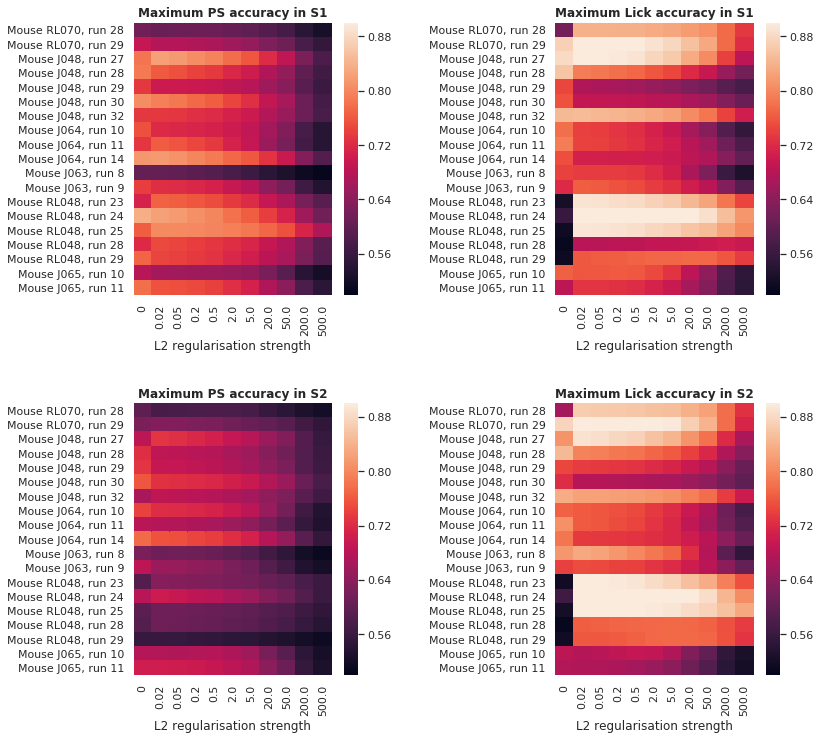

In [388]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

for i_reg, reg in enumerate(['s1', 's2']):
    max_acc_scores = dict_cv_results[reg]
    n_sessions = len(max_acc_scores)
    n_cvalues = max_acc_scores[0].shape[0]
    dict_max_acc_all = {xx: np.zeros((n_sessions, n_cvalues)) for xx in ['PS', 'Lick']}
    for key, acc in max_acc_scores.items():
        dict_max_acc_all['Lick'][key, :] = acc[:, 0]
        dict_max_acc_all['PS'][key, :] = acc[:, 1]

    c_labels = [0] + [1/c for c in c_value_array]
    ss_labels = [str(ss) for key, ss in sessions.items()]

    for i_plot, xx in enumerate(['PS', 'Lick']):
        plt.subplot(2, 2, i_plot + 1 + (i_reg * 2))
        ax1 = sns.heatmap(dict_max_acc_all[xx], xticklabels=c_labels, yticklabels=ss_labels, vmin=0.5, vmax=0.9)
    #     plt.xlabel('1/C value of L2 regularisation'); plt.title(f'Maximum {xx} test accuracy during 3 seconds post-stim')
        plt.xlabel('L2 regularisation strength'); plt.title(f'Maximum {xx} accuracy in {reg.upper()}', weight='bold')

        bottom, top = ax1.get_ylim()
        ax1.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('figures/optimise_regularisation.pdf', bbox_inches='tight')

In [27]:
df_details = pof.create_df_table_details(sessions=sessions, exclude_150stim=True)
df_details
# df_details.to_latex(index=False)  # print latex Tabular code

Mouse Run f (Hz) $N$S1 $N$S2 Trials (excl 150) Hit  FP Miss   CR UR Hit  \
0   J064  10     30   319   152               115  28  28   15   31      2   
1   J064  11     30   536   252               105  24  13   21   31      0   
2   J064  14     30   631   288               140  35  25   24   35      0   
3  RL070  28     30   333   259               258  21   4   85  120      4   
4  RL070  29     30   399   284               179  39  17   33   73      2   
5  RL116  32     30   254    46               204  35  31   19   75      1   
6  RL116  33     30   271    58               144  29  12   28   59      0   
7  RL117  29     30   318   159               186  47  16   30   70      1   
8  RL117  30     30   335   194               127  12   5   42   56      0   
9  RL123  22     30   307   187               111  34  18   14   37      1   

  AR Miss Too early Spont  
0       2         9    10  
1       2        14    10  
2       4        17     9  
3      24         0    10  
4       8         7    10  
5       1        42    10  
6       8         8    10  
7      13         9     0  
8      10         2    10  
9       5         2    10

In [26]:
# print(sessions[5])
sessions[5].pre_rew_trials

array([], shape=(477, 0, 300), dtype=float64)

In [7]:
# ss.spiral_lick[3] < 1000
# ss.autorewarded
sessions[0].pre_rew_trials.shape#[sessions[0].autorewarded]


(471, 10, 300)

In [52]:
for ss in sessions.values():
    print(ss, ss.outcome[ss.autorewarded])

Mouse J064, run 10 ['arm' 'arm']
Mouse J064, run 11 ['arm' 'arm' 'arm']
Mouse J064, run 14 ['arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm']
Mouse RL070, run 28 ['arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm'
 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm'
 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm']
Mouse RL070, run 29 ['arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm']
Mouse RL117, run 29 ['arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm'
 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm']
Mouse RL117, run 30 ['miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss'
 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss']
Mouse RL123, run 22 ['miss' 'miss' 'miss' 'miss' 'miss' 'miss' 'miss']
Mouse RL116, run 32 ['arm']
Mouse RL116, run 33 ['arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'arm' 'ar

In [36]:
assert np.unique(sessions[0].outcome[sessions[0].unrewarded_hits]) == ['urh']
# sessions[0].autorewarded
# sessions[7]

In [159]:
print('Total number of imaged cells is', df_details[r"$N$" + 'S2'].sum() + df_details[r"$N$" + 'S1'].sum())

Total number of imaged cells is 3790


In [160]:
# np.sum(sessions[14].unrewarded_hits)
print('FIRST LICK TIMES FOR UR HITS FOR ALL SESSIONS\n')
for i_ss, sess in sessions.items():
    print(sess, '\n')
#     print('ratio UR hit / AR miss',
#           np.sum(np.logical_and(sess.autorewarded, sess.unrewarded_hits)) / np.sum(sess.autorewarded))
    for ii, triall in enumerate(sess.nonnan_trials):
        if sess.unrewarded_hits[ii]:
            print('UH', sess.run.spiral_licks[triall][0])
    #     elif sessions[14].outcome[ii] == 'hit':
    #         print('H', sess.run.spiral_licks[triall][0])
    print('-------------------------------\n')

FIRST LICK TIMES FOR UR HITS FOR ALL SESSIONS

Mouse J065, run 11 



AttributeError: 'SessionLite' object has no attribute 'run'

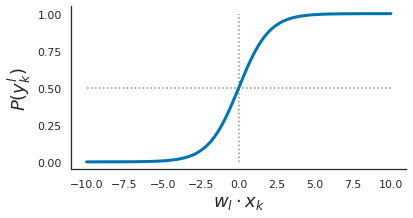

In [54]:
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 20
tmp = plt.subplot(111)
x_array = np.linspace(-10, 10, 601)
y_array = 1 / (1 + np.exp(-1 * x_array))
tmp.plot([0, 0], [0, 1], color='k', alpha=0.5, linestyle=':')
tmp.plot([-10, 10], [0.5, 0.5], color='k', alpha=0.5, linestyle=':')
tmp.plot(x_array, y_array, linewidth=3)
tmp.set_xlabel(r"$w_l \cdot x_k$", fontdict={'fontsize': 18})
tmp.set_ylabel(r"$P(y_k^l)$", fontdict={'fontsize': 18})
tmp.set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
sns.despine()